In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/Histopathologic Cancer Detection using CNNs/histopathologic-cancer-detection.zip"

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: train/fa2c546059bd262cbe954dfdba24dc0d67f598b0.tif  
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif 

In [3]:
import tifffile as tif
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import os
import pandas as pd
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
print('Number of images in trainset :',len(os.listdir('train')))
print('Number of images in testset  :',len(os.listdir('test')))

Number of images in trainset : 220025
Number of images in testset  : 57458


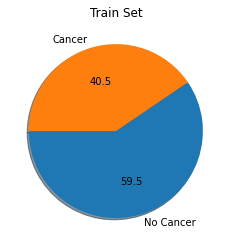

0    130908
1     89117
Name: label, dtype: int64


In [4]:
labels_train=pd.read_csv('train_labels.csv')
labels_count_train = labels_train.label.value_counts()

%matplotlib inline
fig,ax = plt.subplots(figsize=(12,4), ncols=1, nrows=1)
ax.pie(labels_count_train, labels=['No Cancer', 'Cancer'], startangle=180, autopct='%1.1f', shadow=True);
ax.set_title('Train Set')

plt.show()

print(labels_count_train)

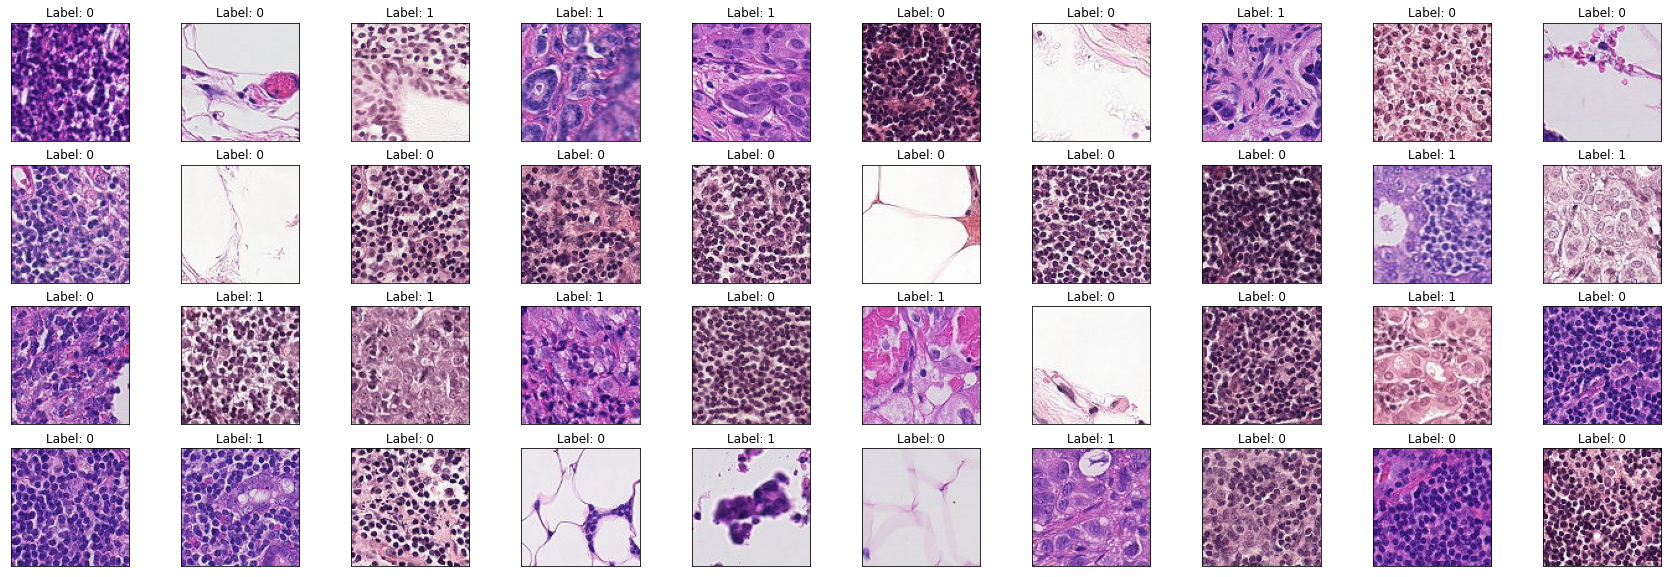

In [ ]:
fig = plt.figure(figsize=(30,10))
# display 20 images
train_imgs = os.listdir("train")
for idx, img in enumerate(np.random.choice(train_imgs, 40)):
    ax = fig.add_subplot(4, 10, idx+1, xticks=[], yticks=[])
    im = PIL.Image.open("train/" + img)
    plt.imshow(im)
    lab = labels_train.loc[labels_train['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title('Label: %s'%lab)
plt.show()

In [ ]:
im = plt.imread("train/" + img)
print(im.shape)

(96, 96, 3)


In [5]:
# Our own custom class for datasets
import torchvision.transforms as tt
# Import PyTorch
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torch.optim as optim
from torchsummary import summary

# Import useful sklearn functions
import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score
from PIL import Image

class CancerDataset(Dataset):
    def __init__(self, df_data, data_dir, transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
# Percentage of training set to use as validation
valid_size = 0.33

# obtain training indices that will be used for validation
num_train = len(labels_train)
indices = list(range(num_train))
np.random.shuffle(indices)

split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_df = labels_train.iloc[train_idx]
valid_df = labels_train.iloc[valid_idx]

print('size of train set :',len(train_df))
print('size of valid set :',len(valid_df))

size of train set : 147417
size of valid set : 72608


In [ ]:
transf_train=tt.Compose([tt.ToPILImage(),
                         tt.RandomRotation(45),
                         tt.RandomVerticalFlip(p=0.25),
                         tt.RandomHorizontalFlip(p=0.2),
                         tt.ToTensor(),
                         tt.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))])

transf_valid=tt.Compose([tt.ToTensor(),tt.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))])

In [ ]:
train_data=CancerDataset(train_df, 'train', transf_train)
valid_data=CancerDataset(valid_df, 'train', transf_valid)

In [ ]:
BATCH_SIZE=64
train_loader=DataLoader(train_data, BATCH_SIZE, shuffle=True)
valid_loader=DataLoader(valid_data, BATCH_SIZE, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


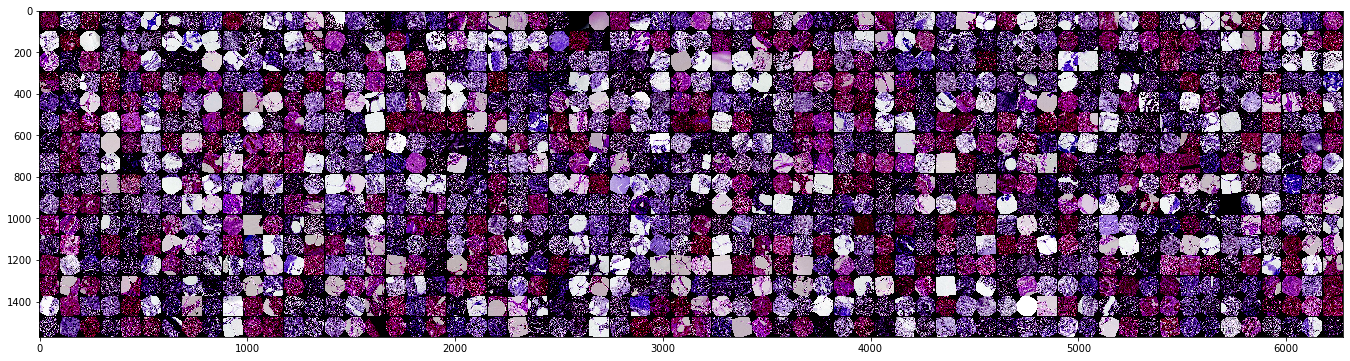

In [ ]:
def show(img):
    npimg = img.numpy()
    plt.figure(figsize=(29,6))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

X, Y = next(iter(DataLoader(train_data, 1024, shuffle=True)))
grid = torchvision.utils.make_grid(X, nrow=64)
show(grid)

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        # Convolutional and Pooling Layers
        self.conv1=nn.Sequential(nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=0),
                                 nn.BatchNorm2d(32),nn.ReLU(inplace=True),nn.MaxPool2d(2,2))
        self.conv2=nn.Sequential(nn.Conv2d(in_channels=32,out_channels=64,kernel_size=2,stride=1,padding=1),
                                 nn.BatchNorm2d(64),nn.ReLU(inplace=True),nn.MaxPool2d(2,2))
        self.conv3=nn.Sequential(nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=0),
                                 nn.BatchNorm2d(128),nn.ReLU(inplace=True),nn.MaxPool2d(2,2))
        self.conv4=nn.Sequential(nn.Conv2d(in_channels=128,out_channels=256,kernel_size=2,stride=1,padding=1),
                                 nn.BatchNorm2d(256),nn.ReLU(inplace=True),nn.MaxPool2d(2,2))
        
        self.flatten=nn.Flatten()
        
        self.fc=nn.Sequential(nn.Linear(9216,1024),nn.ReLU(inplace=True),nn.Dropout(0.4),
                              nn.Linear(1024,512), nn.ReLU(inplace=True),nn.Dropout(0.4),
                              nn.Linear(512, 1),nn.Sigmoid())
    def forward(self, x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        
        x=x.view(x.shape[0],-1)
#         print(x.shape)
        
        x=self.fc(x)
        return x

In [7]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
model=CNN()
if train_on_gpu:
    model=model.cuda()

summary(model, (3,96,96))

In [ ]:
# specify loss function (categorical cross-entropy loss)
criterion = nn.BCELoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00015)

In [ ]:
# number of epochs to train the model
n_epochs = 10

valid_loss_min = np.Inf

# keeping track of losses as it happen
train_losses = []
valid_losses = []
train_auc = []
valid_auc = []
auc_epoch_train = []
auc_epoch_valid = []

for epoch in range(0, n_epochs):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        target = target.view(-1, 1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()

        if (i+1)%(len(train_loader)//10) == 0:
            print('Train Epoch {}/{} [{:.0f}%] : \tLoss : {:.5f}'
            .format(epoch+1,n_epochs,100.*(i+1)/len(train_loader), loss.detach().item()))

        # Update Train loss and accuracies
        train_loss += loss.item()*data.size(0)
        y_actual = target.data.cpu().numpy()
        y_pred = output[:,-1].detach().cpu().numpy()
        train_auc.append(roc_auc_score(y_actual, y_pred)) 
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        # forward pass: compute predicted outputs by passing inputs to the model
        target = target.view(-1, 1)
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        #output = output.topk()
        y_actual = target.data.cpu().numpy()
        y_pred = output[:,-1].detach().cpu().numpy()
        valid_auc.append(roc_auc_score(y_actual, y_pred)) 
        
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_auc_epoch = np.mean(train_auc)
    valid_auc_epoch = np.mean(valid_auc)

    auc_epoch_train.append(np.mean(train_auc))
    auc_epoch_valid.append(np.mean(valid_auc))

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print training/validation statistics 
    print('\tEpoch {}/{} : Loss: {:.4f} | Val_Loss: {:.4f} || AUC: {:.4f} | Val_AUC: {:.4f}\n'
    .format(epoch+1,n_epochs, train_loss, valid_loss, train_auc_epoch, valid_auc_epoch))

Train Epoch 1/10 [10%] : 	Loss : 0.36121
Train Epoch 1/10 [20%] : 	Loss : 0.38622
Train Epoch 1/10 [30%] : 	Loss : 0.46450
Train Epoch 1/10 [40%] : 	Loss : 0.34024
Train Epoch 1/10 [50%] : 	Loss : 0.23043
Train Epoch 1/10 [60%] : 	Loss : 0.34543
Train Epoch 1/10 [70%] : 	Loss : 0.30989
Train Epoch 1/10 [80%] : 	Loss : 0.29354
Train Epoch 1/10 [90%] : 	Loss : 0.37670
Train Epoch 1/10 [100%] : 	Loss : 0.37915
	Epoch 1/10 : Loss: 0.3766 | Val_Loss: 0.3021 || AUC: 0.9118 | Val_AUC: 0.9435

Train Epoch 2/10 [10%] : 	Loss : 0.21744
Train Epoch 2/10 [20%] : 	Loss : 0.29753
Train Epoch 2/10 [30%] : 	Loss : 0.45861
Train Epoch 2/10 [40%] : 	Loss : 0.42132
Train Epoch 2/10 [50%] : 	Loss : 0.26499
Train Epoch 2/10 [60%] : 	Loss : 0.27397
Train Epoch 2/10 [70%] : 	Loss : 0.16872
Train Epoch 2/10 [80%] : 	Loss : 0.31221
Train Epoch 2/10 [90%] : 	Loss : 0.23377
Train Epoch 2/10 [100%] : 	Loss : 0.25900
	Epoch 2/10 : Loss: 0.3134 | Val_Loss: 0.2957 || AUC: 0.9266 | Val_AUC: 0.9479

Train Epoch 3/10 [

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Histopathologic Cancer Detection using CNNs/final_model.pt')
torch.save(optimizer.state_dict(), '/content/drive/MyDrive/Histopathologic Cancer Detection using CNNs/final_optimizer.pt')

In [ ]:
torch.save({'train_loader':train_loader,
            'valid_loader':valid_loader,
            'epochs': n_epochs,
            'train_losses': train_losses,
            'valid_losses': valid_losses,
            'auc_epoch_train':auc_epoch_train,
            'auc_epoch_valid':auc_epoch_valid}, '/content/drive/MyDrive/Histopathologic Cancer Detection using CNNs/checkpoint.pt')

In [ ]:
checkpoint=torch.load('/content/drive/MyDrive/Histopathologic Cancer Detection using CNNs/checkpoint.pt')

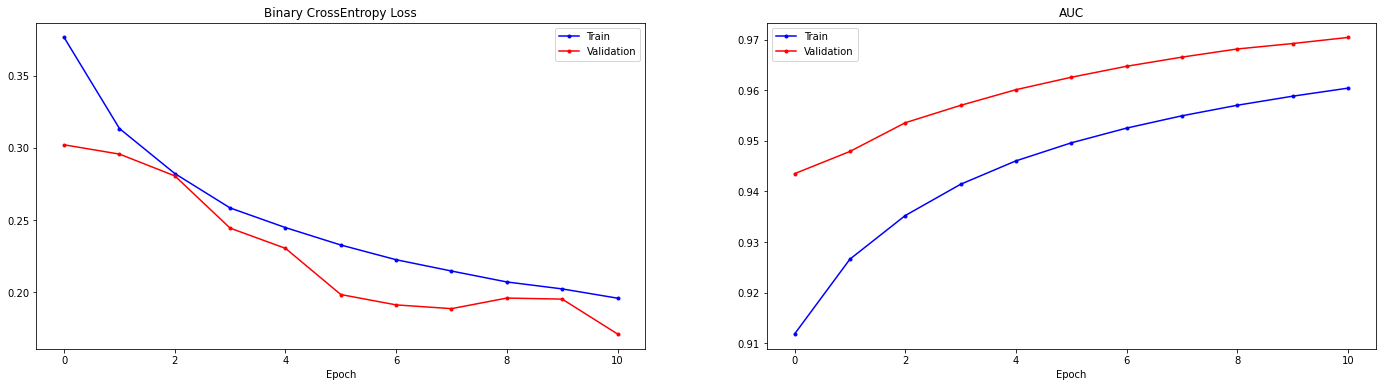

In [ ]:
plt.figure(figsize=(24,6))
plt.subplot(121)
plt.plot(train_losses, label='Train', color='blue',marker='.');
plt.plot(valid_losses, label='Validation', color='red',marker='.');
plt.legend(loc='best');
plt.xlabel('Epoch');
plt.title('Binary CrossEntropy Loss');

plt.subplot(122)
plt.plot(auc_epoch_train, label='Train', color='blue',marker='.');
plt.plot(auc_epoch_valid, label='Validation', color='red',marker='.');
plt.legend(loc='best');
plt.xlabel('Epoch');
plt.title('AUC');

plt.show()

In [ ]:
from tqdm import tqdm 
def get_predictions(data_loader):
    y_preds=torch.zeros(0,dtype=torch.long, device='cpu')
    y_true=torch.zeros(0,dtype=torch.long, device='cpu')
    y_proba=torch.zeros(0,dtype=torch.long, device='cpu')
    
    model.eval()
    with torch.no_grad():
        for data, target in tqdm(data_loader):
            if train_on_gpu:
                data, target = data.cuda(), target.cuda().float()
            output = model(data)
            pred =  output.detach().round()

            y_preds=torch.cat([y_preds,pred.view(-1).cpu()])
            y_true=torch.cat([y_true,target.view(-1).cpu()])
            y_proba=torch.cat([y_proba,output.view(-1).cpu()])
    return y_true, y_preds, y_proba

In [ ]:
y_true_train, y_preds_train, y_proba_train = get_predictions(train_loader)
y_true_valid, y_preds_valid, y_proba_valid = get_predictions(valid_loader)

100%|██████████| 1135/1135 [01:46<00:00, 10.70it/s]


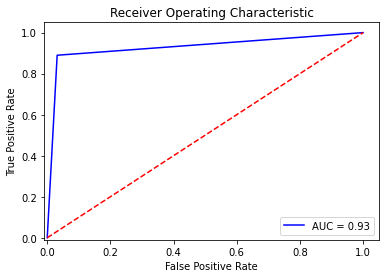

In [ ]:
from sklearn.metrics import auc, roc_curve
fpr, tpr, threshold = roc_curve(y_true_valid, y_preds_valid)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.05])
plt.ylim([-0.01, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, precision_score, recall_score, f1_score

results=pd.DataFrame(index=np.arange(3), columns=['Set','F1 Score', 'Precision', 'Recall', 'Balanced Accuracy'])
base=['Train','Validation']
i=0
for (true,pred) in [(y_true_train, y_preds_train), (y_true_valid, y_preds_valid)]:
    p=precision_score(true,pred).item()
    r=recall_score(true,pred).item()
    f1=f1_score(true,pred).item()
    ba=balanced_accuracy_score(true,pred).item()
    results.iloc[i]=[base[i]]+[100*np.round(e,4) for e in [p,r,f1,ba]]
    i+=1
results

,Set,F1 Score,Precision,Recall,Balanced Accuracy
0,Train,95.21,87.57,91.23,92.29
1,Validation,95.1,88.97,91.93,92.92
2,NaN,NaN,NaN,NaN,NaN
